In [1]:
%load_ext autoreload
%autoreload 2

In [68]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from sleep_stage_classifier.data_model import PSG, Hypnogram
from sleep_stage_classifier.config import DATA_DIR, PARTICIPANT_SHEET_XLS, PARTICIPANT_SHEET

In [69]:
sc_participants = pd.read_excel(
    PARTICIPANT_SHEET_XLS['SC']
)

st_participants = pd.read_excel(
    PARTICIPANT_SHEET_XLS['ST']
)

sc_participants.rename(columns={'subject': 'participant_id'}, inplace=True)
sc_participants['gender'] = sc_participants['sex (F=1)'].apply(lambda x: 'F' if x == 1 else 'M')
sc_participants.drop(columns=['sex (F=1)'], inplace=True)


st_participants.loc[0, 'Subject - age - sex'] = 'participant_id'
st_participants.loc[0, 'Unnamed: 1'] = 'age'
st_participants.loc[0, 'Placebo night'] = 'Placebo night'
st_participants.loc[0, 'Temazepam night'] = 'Temazepam night'
st_participants.loc[0, 'Unnamed: 4'] = 'Placebo night lights off'
st_participants.loc[0, 'Unnamed: 6'] = 'Temazepam night lights off'
st_participants.columns = st_participants.iloc[0]
st_participants = st_participants.drop(0)
st_participants['gender'] = st_participants['M1/F2'].apply(lambda x: 'M' if x == 1 else 'F')
st_participants.drop(columns=['M1/F2'], inplace=True)

night_df = st_participants.melt(id_vars=['participant_id', 'age', 'gender'], value_vars=['Placebo night', 'Temazepam night'], var_name='drug_night', value_name='night')
lights_off_df = st_participants.melt(id_vars=['participant_id', 'age', 'gender'], value_vars=['Placebo night lights off', 'Temazepam night lights off'], var_name='drug_lights_off', value_name='lights off')
night_df['drug'] = night_df['drug_night'].str.extract('(Placebo|Temazepam)')
lights_off_df['drug'] = lights_off_df['drug_lights_off'].str.extract('(Placebo|Temazepam)')
night_df.drop(columns='drug_night', inplace=True)
lights_off_df.drop(columns='drug_lights_off', inplace=True)
st_participants = pd.merge(night_df, lights_off_df, on=['participant_id', 'age', 'gender', 'drug'])

sc_participants.rename(columns={
    'LightsOff': 'lights_off_time'
}, inplace=True)

st_participants.rename(columns={
    'lights off': 'lights_off_time'    
}, inplace=True)

sc_participants['study'] = 'SC' 
st_participants['study'] = 'ST'


In [70]:
columns_interested = ['participant_id', 'night', 'age', 'gender', 'lights_off_time', 'study']
participants = pd.concat([sc_participants[columns_interested], st_participants[columns_interested]], axis=0)
participants['session_id'] = participants.apply(lambda row: f"{row['study']}{'4' if row['study'] == 'SC' else '7'}{str(row['participant_id']).zfill(2)}{row['night']}", axis=1)
participants


,participant_id,night,age,gender,lights_off_time,study,session_id
0,0,1,33,F,00:38:00,SC,SC4001
1,0,2,33,F,21:57:00,SC,SC4002
2,1,1,33,F,22:44:00,SC,SC4011
3,1,2,33,F,22:15:00,SC,SC4012
4,2,1,26,F,22:50:00,SC,SC4021
...,...,...,...,...,...,...,...
39,19,1,28,F,23:44:00,ST,ST7191
40,20,2,24,M,00:01:00,ST,ST7202
41,21,1,34,F,23:10:00,ST,ST7211
42,22,2,56,M,23:44:00,ST,ST7222


In [71]:
assert participants['session_id'].nunique() == participants.shape[0] 

In [72]:
psg_files = [f for f in os.listdir(DATA_DIR) if f.endswith('PSG.edf')]
hypnogram_files = [f for f in os.listdir(DATA_DIR) if f.endswith('Hypnogram.edf')]
len(psg_files), len(hypnogram_files), participants.shape[0]

(197, 197, 197)

In [73]:
session_to_files = {}

for session_id in tqdm(participants['session_id']):
    session_to_files[session_id] = {
        'psg_file': None,
        'hypnogram_file': None
    }
    for f in psg_files:
        if session_id in f:
            session_to_files[session_id]['psg_file'] = f
            break
    for f in hypnogram_files:
        if session_id in f:
            session_to_files[session_id]['hypnogram_file'] = f
            break
    
    assert session_to_files[session_id]['psg_file'] is not None and session_to_files[session_id]['hypnogram_file'] is not None, f"Missing files for {session_id}"

100%|██████████| 197/197 [00:00<00:00, 96482.71it/s]


In [74]:
def get_file_path(session_id, file_type):
    file_name = session_to_files[session_id][f"{file_type}_file"]
    return os.path.join(DATA_DIR, file_name)

participants['psg_file'] = participants['session_id'].apply(lambda x: get_file_path(x, 'psg'))
participants['hypnogram_file'] = participants['session_id'].apply(lambda x: get_file_path(x, 'hypnogram'))

In [76]:
participants.to_csv(PARTICIPANT_SHEET, index=False)

In [77]:
psg_file = participants.iloc[0]['psg_file']
hypnogram_file = participants.iloc[0]['hypnogram_file']

psg = PSG(psg_file)
hypnogram = Hypnogram(hypnogram_file)

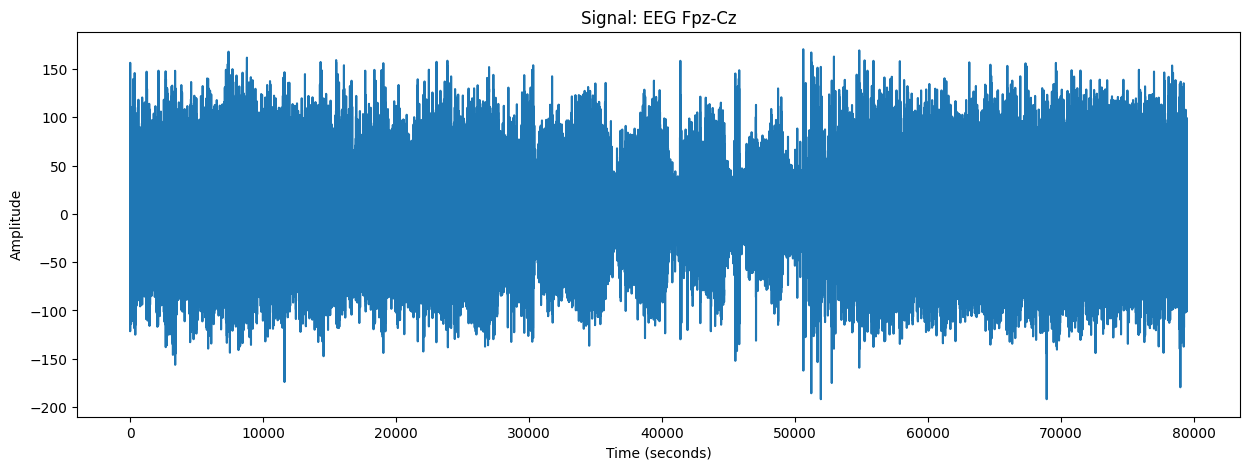

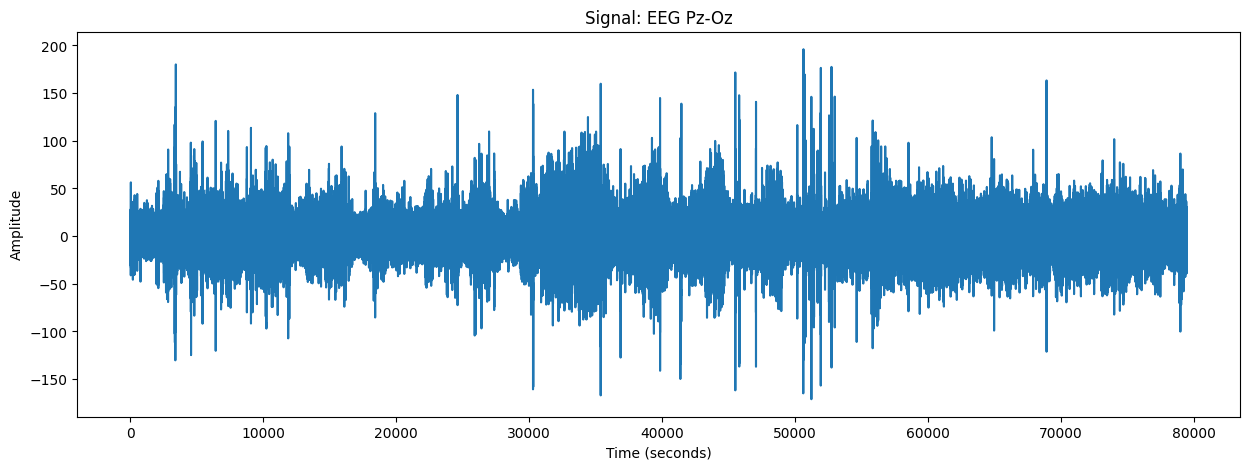

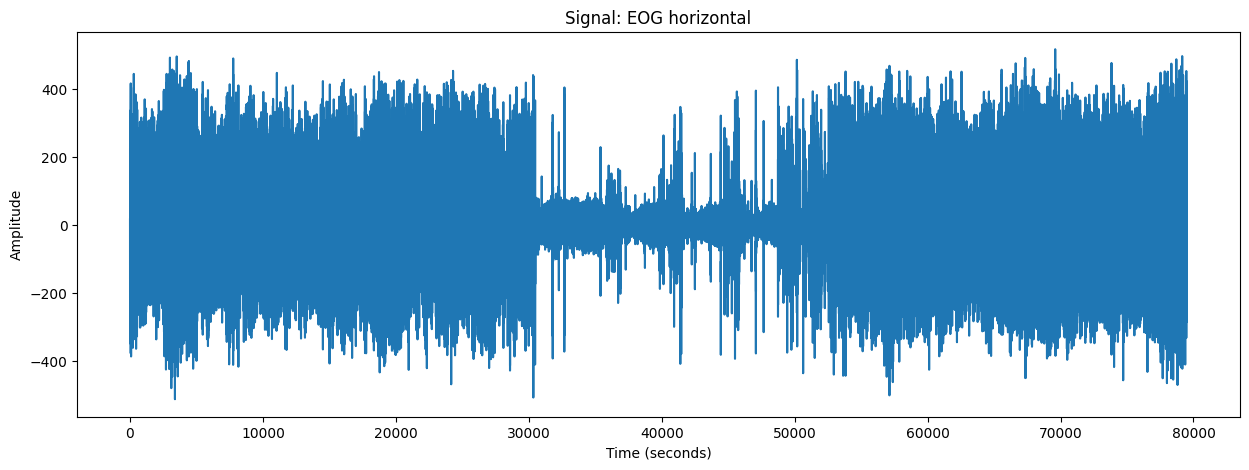

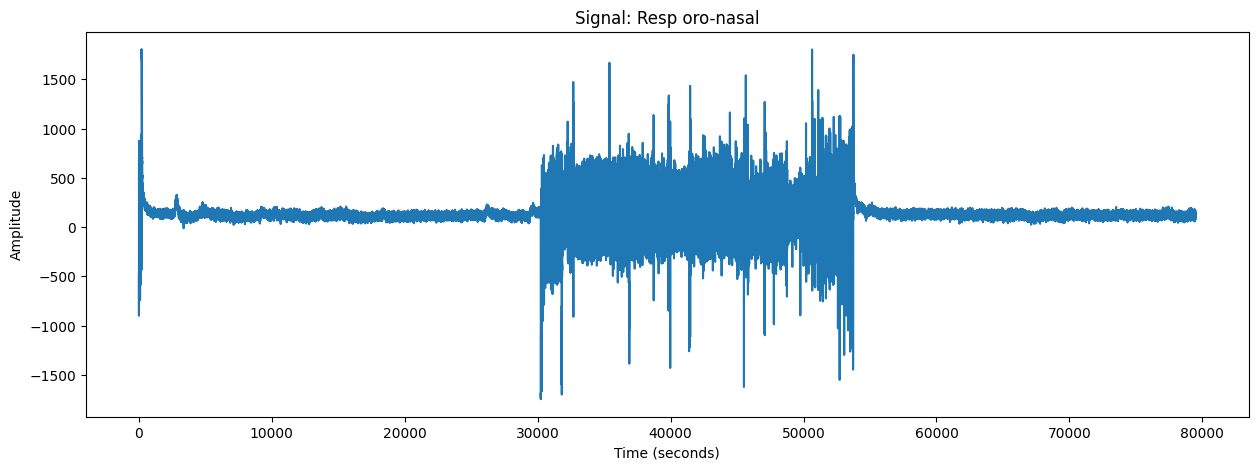

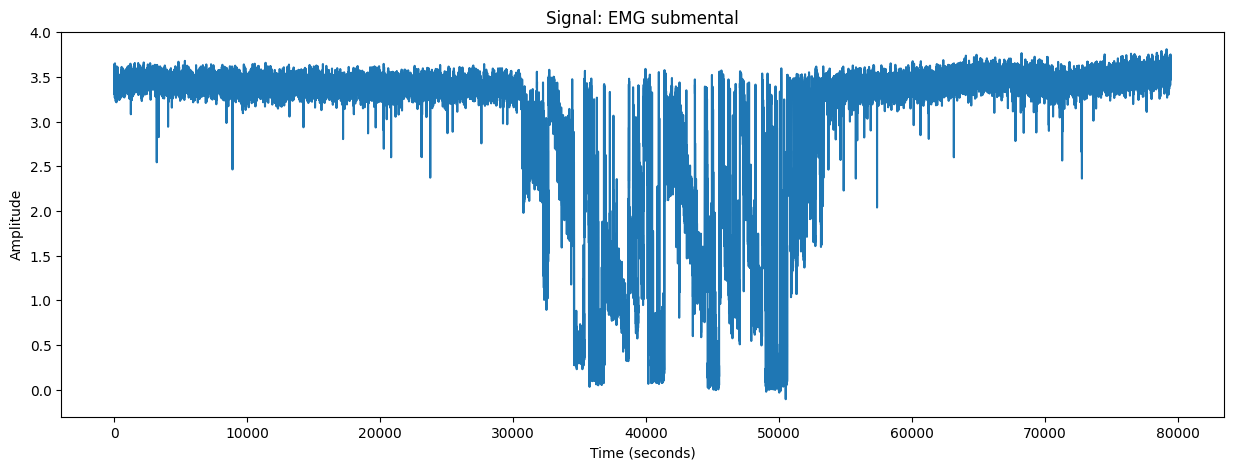

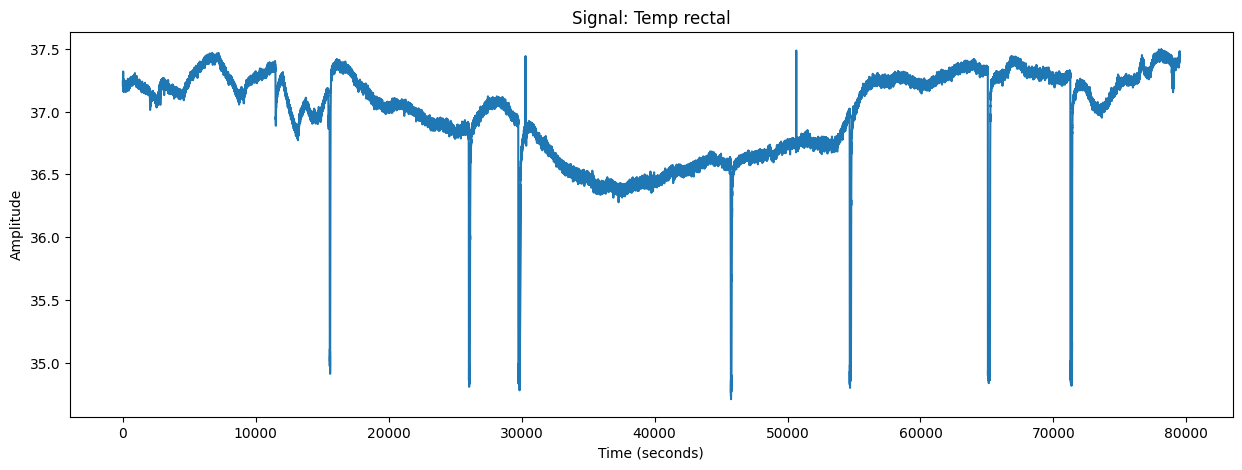

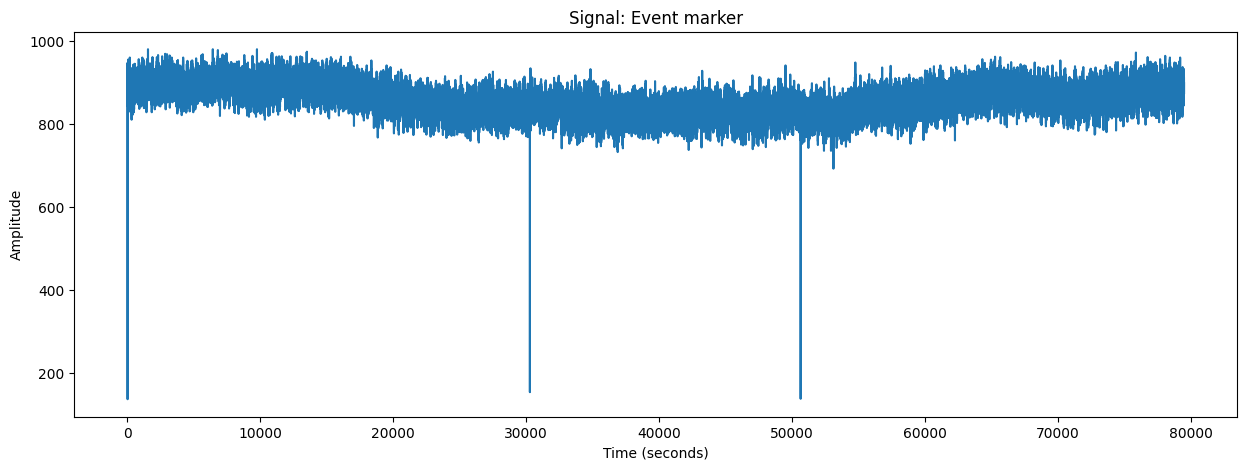

In [79]:
for signal_label in psg.get_signal_labels():
    psg.plot_signal(signal_label)

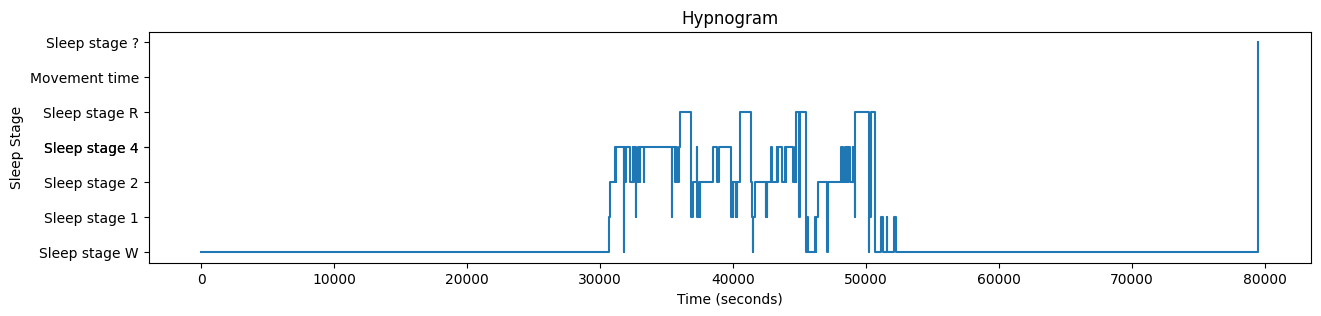

In [80]:
hypnogram.plot_stages()

In [82]:
from sleep_stage_classifier.data_viz.plotting import plot_signal_with_stages

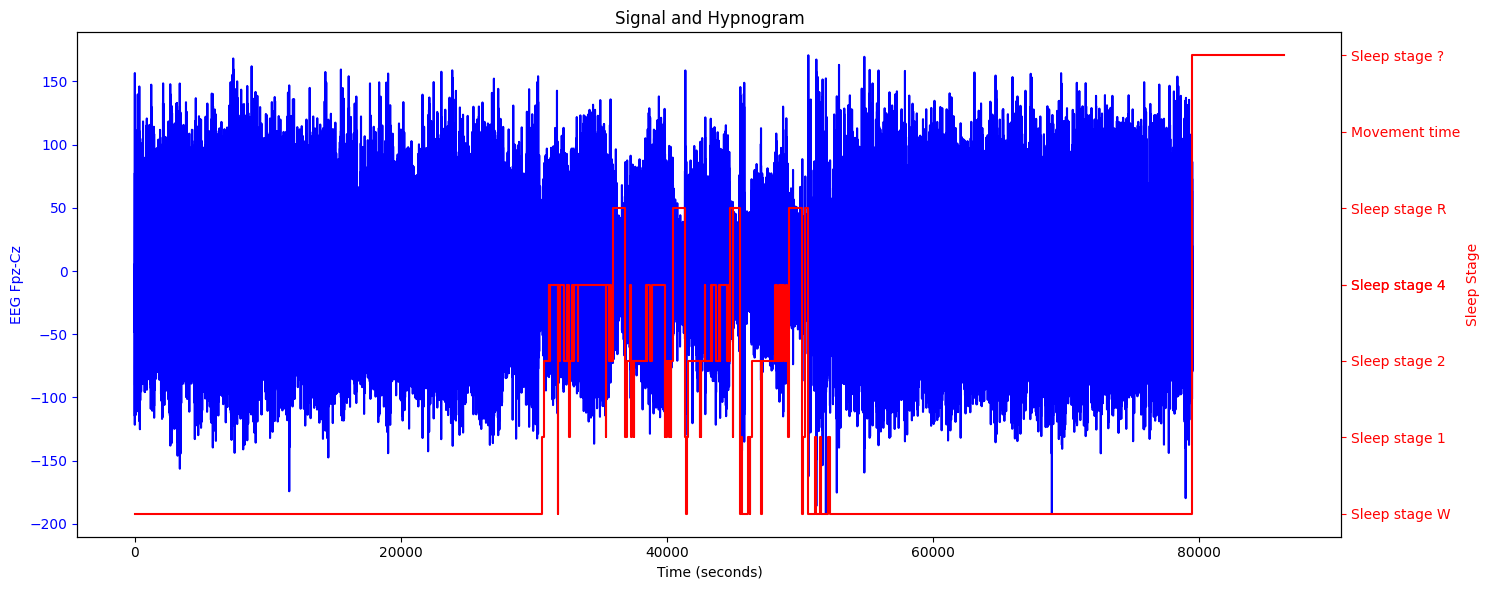

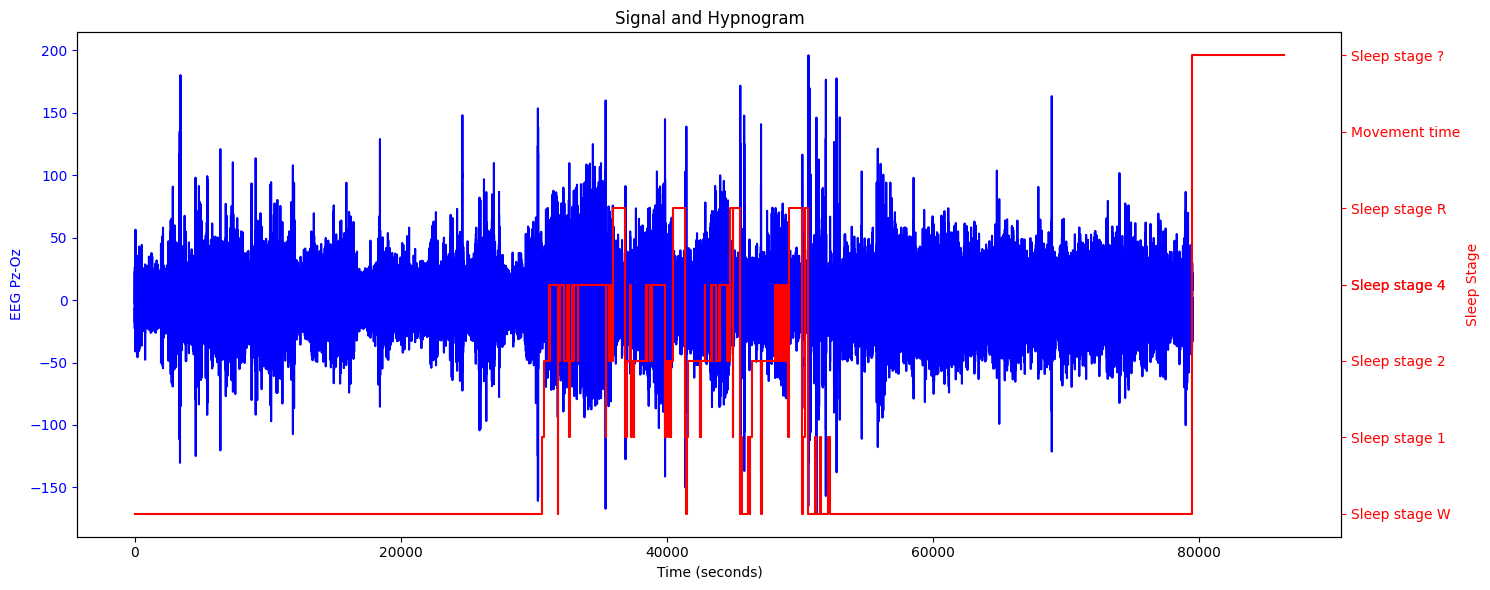

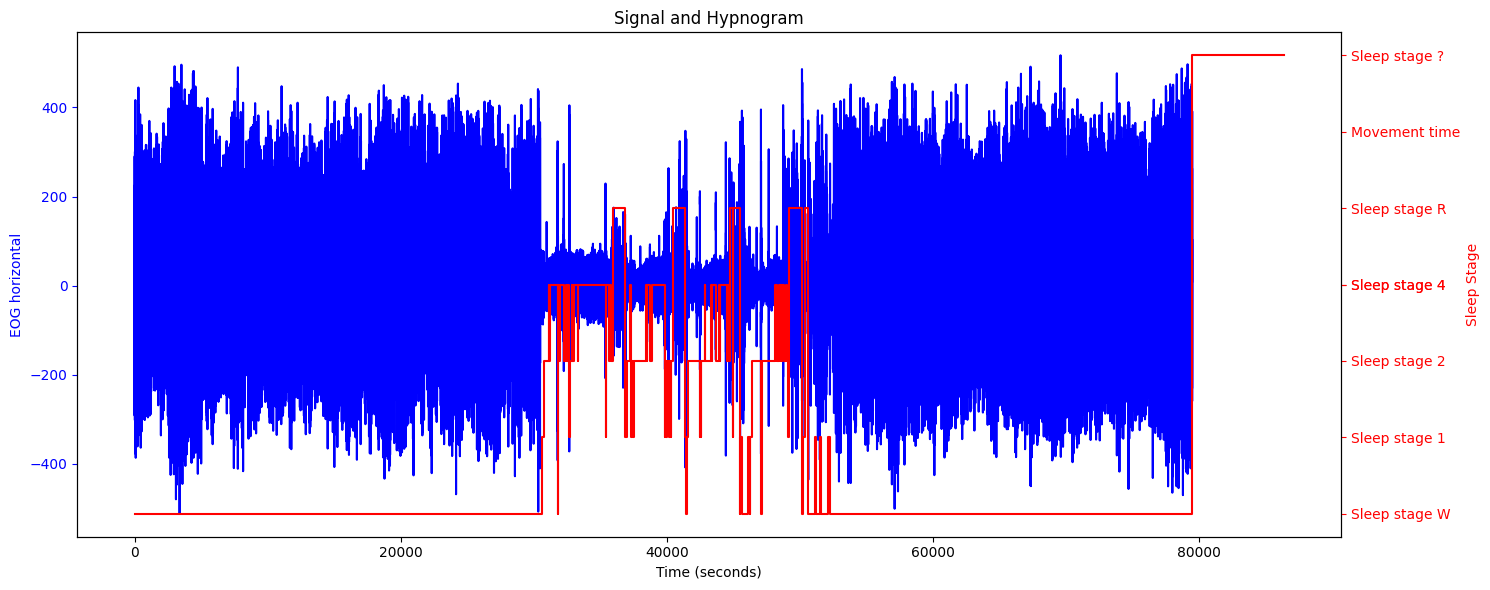

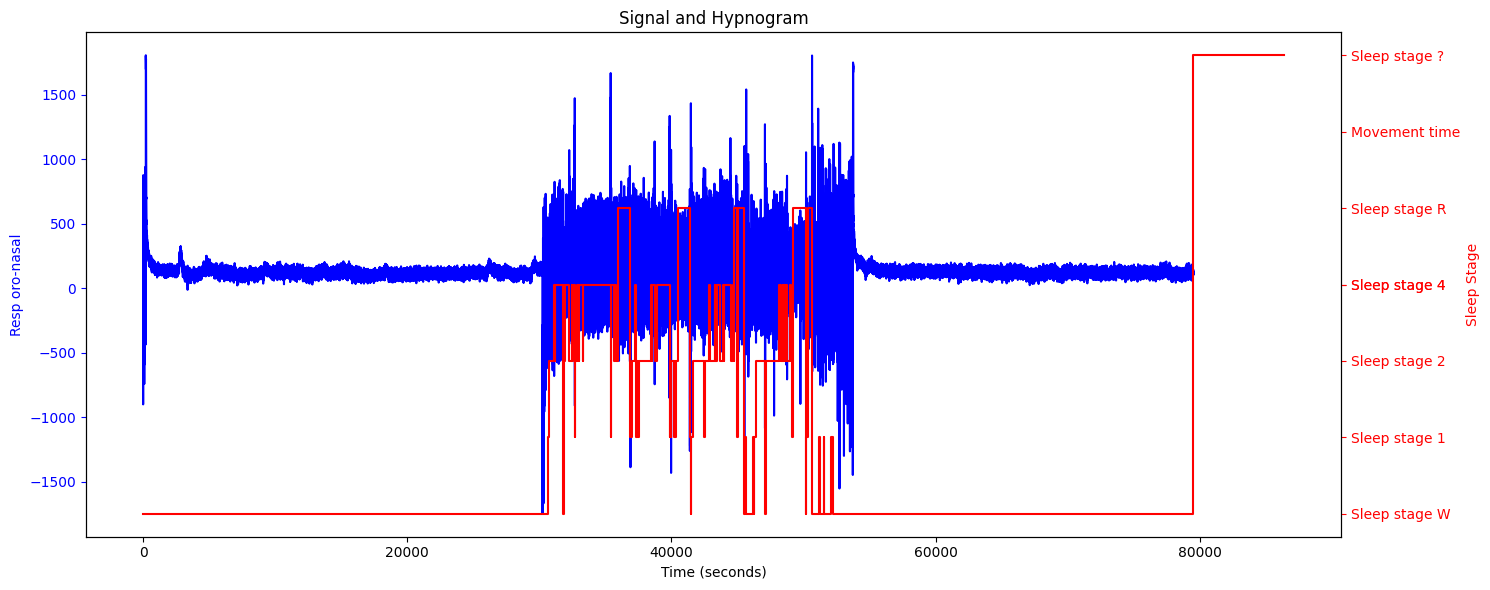

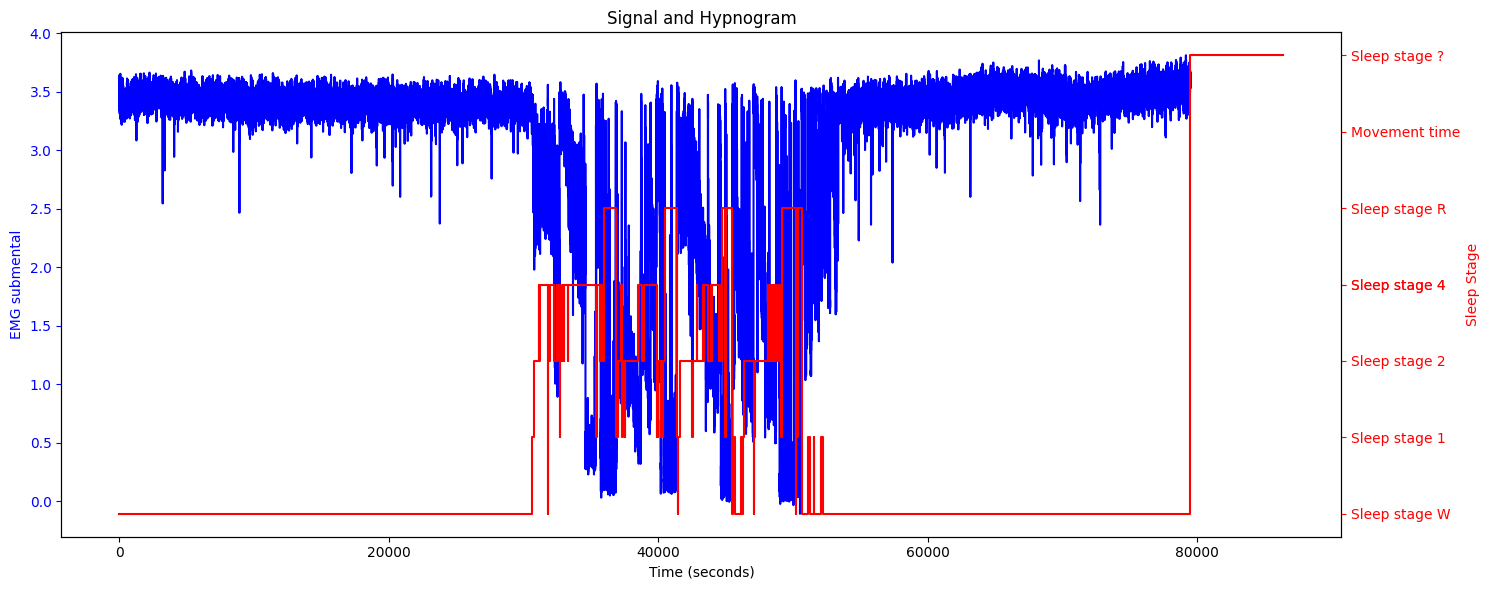

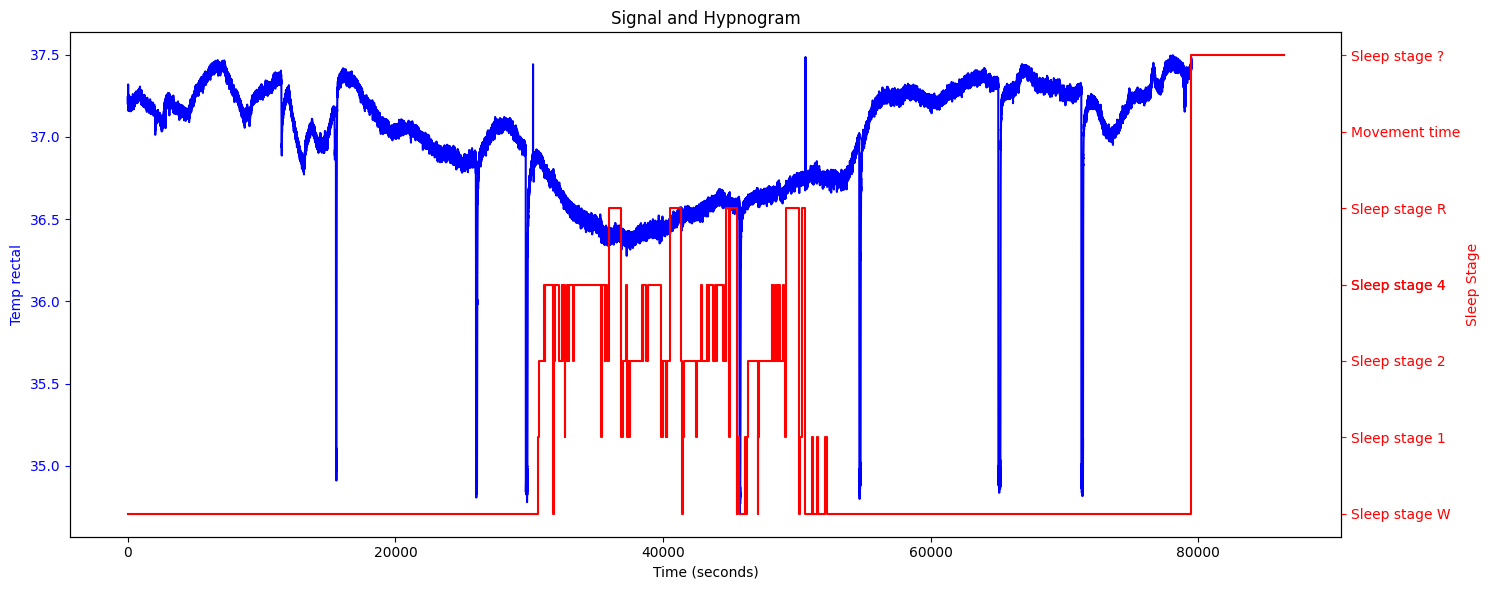

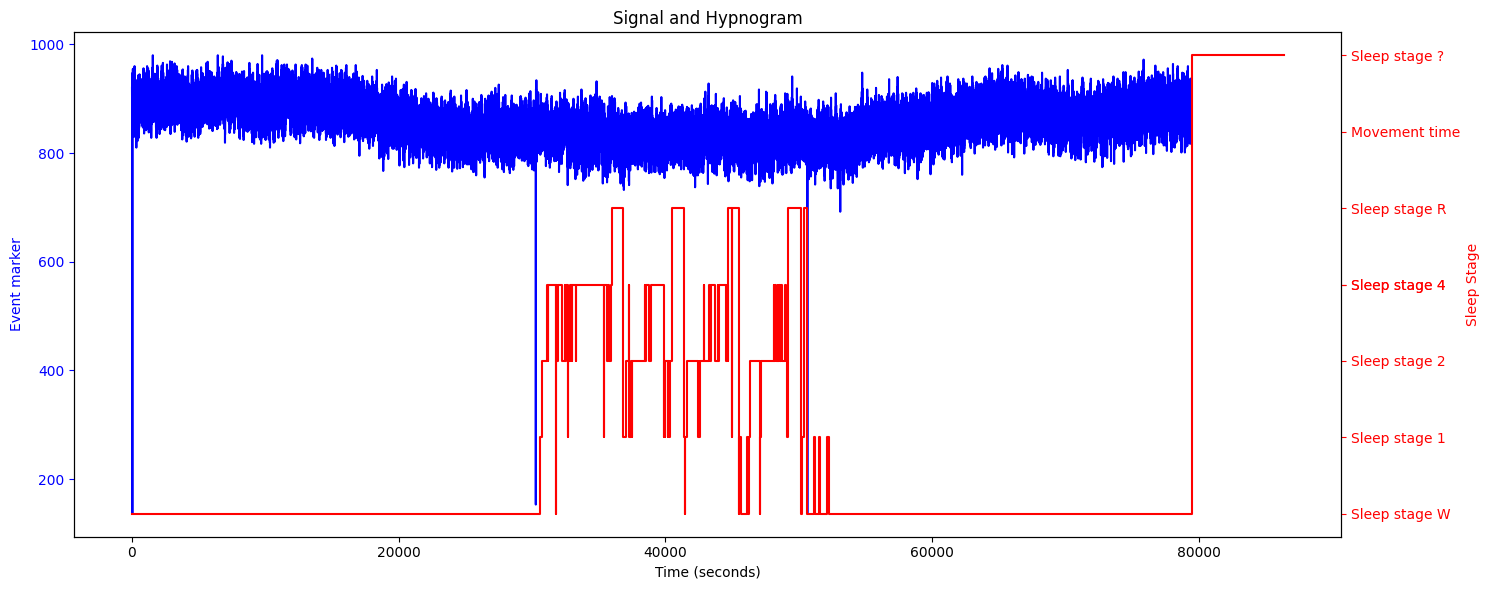

In [83]:
for label in psg.get_signal_labels():
    plot_signal_with_stages(psg, hypnogram, label)